### Machine Learning Midterm I (Tigran Avetisyan)
#### Grade 100/100

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import statsmodels.formula.api as smf
import lmdiag

from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, LinearRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor

plt.style.use("seaborn-white")
warnings.filterwarnings('ignore')

### Some functions that make our life easy

In [2]:
# Function to evaluate Adjusted R-squared

def adj_rsquared(model, X, y):
    Rsquared = model.score(X, y)
    n = X.shape[0]
    p = X.shape[1]
    
    adj_r2 = 1 - (1 - Rsquared) * (n - 1)/(n - p - 1)
    
    return adj_r2

In [3]:
# Function to draw boxplots for given categories and response

def boxplots(df, categories, response):
    for category in categories:
        if category != response:
            plt.figure(figsize = (9, 7))
            sns.boxplot(data = df, x = category, y = response)
            plt.show()

In [4]:
# Function to see core information about our data

def core_info(df):
    print(df.info())
    print("------------------------------------------------")
    print(df.describe())
    print("------------------------------------------------")
    print(df.head())
    print("------------------------------------------------")
    print(df.shape)

In [5]:
# Pairwise scatter plot function for given features and response

def pairwise_plot(df, features, response, degree = 1):
    for feature in features:
        if response != feature:
            plt.scatter(x = feature, y = response, data = df, facecolors = "None", edgecolors = "k", alpha = .5)
            sns.regplot(x = feature, y = response, data = df, scatter = False, color = "red", ci = None)
            plt.show()

### Understanding the data

In [6]:
data = pd.read_csv('Data/UVW_exam.csv')
core_info(data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   A         2000 non-null   float64
 1   B         2000 non-null   float64
 2   C         2000 non-null   float64
 3   D         2000 non-null   float64
 4   E         2000 non-null   float64
 5   F         2000 non-null   float64
 6   G         2000 non-null   float64
 7   H         2000 non-null   float64
 8   I         1999 non-null   object 
 9   J         1999 non-null   object 
 10  Response  2000 non-null   float64
dtypes: float64(9), object(2)
memory usage: 172.0+ KB
None
------------------------------------------------
                 A            B            C            D            E  \
count  2000.000000  2000.000000  2000.000000  2000.000000  2000.000000   
mean      3.815285     0.005757     0.013875    -0.007037     0.032480   
std     146.228785     1.021186     1.015331     1.01927

In [7]:
data.head()

,A,B,C,D,E,F,G,H,I,J,Response
0,-345.694695,-0.229175,-1.481270,1.659987,-1.172292,-0.256532,1.633161,0.277218,black,male,-1.878414
1,209.548322,1.886725,0.213200,-1.150973,1.242473,-0.717337,1.794418,-1.475029,white,male,0.770835
2,191.133034,-1.666423,1.200566,0.427946,-0.314049,0.633903,-0.349396,-0.625093,white,male,0.958645
3,-96.734132,-0.380127,-1.167657,-0.834316,0.484875,0.061835,0.674873,0.208940,white,male,-0.738064
4,338.020349,-1.222810,0.540495,0.021875,-1.038014,0.988782,0.643261,-2.135315,white,female,0.937555


From the above cells we can see that we have 2000 observations and 11 features. We have two categorical variables I and J, also A, B, C, D, E, F, G, H and Response as a numerical features. 

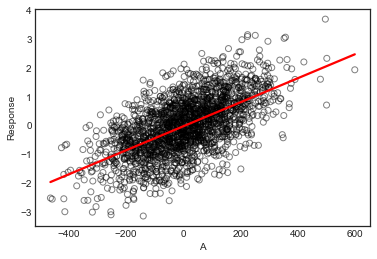

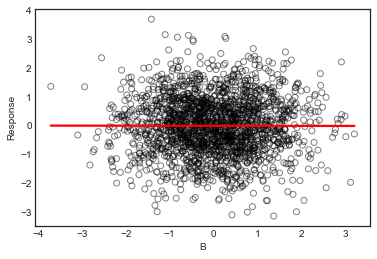

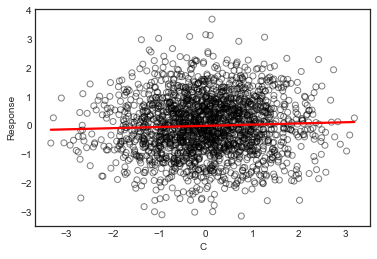

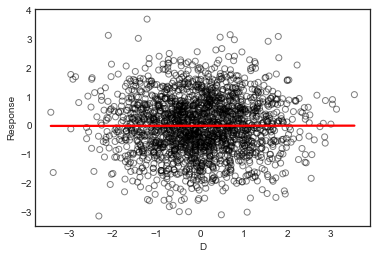

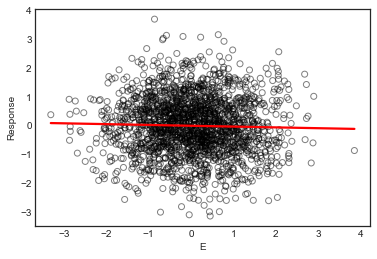

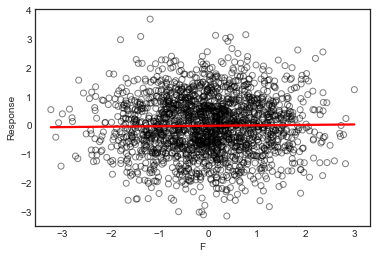

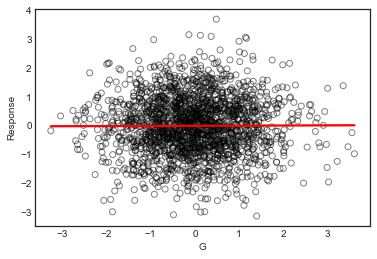

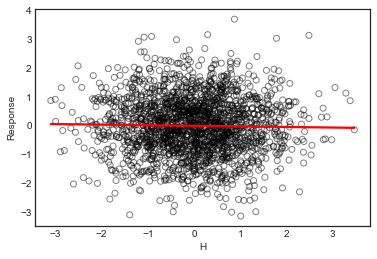

In [8]:
# Using pairwise scatter plot function defined above

response = data["Response"]
features = "A B C D E F G H".split()

pairwise_plot(data, features, "Response")

Above we can see that variable A is the best feature that is correlated with the Response. Rest of the features are just spread around the 0 line.

In [9]:
data.dtypes

A           float64
B           float64
C           float64
D           float64
E           float64
F           float64
G           float64
H           float64
I            object
J            object
Response    float64
dtype: object

In [10]:
data.I.value_counts()

white    1000
black     999
Name: I, dtype: int64

In [11]:
black_percentage = (data.loc[data.I == "black"].shape[0]/data.I.shape[0])*100
white_percentage = (data.loc[data.I == "white"].shape[0]/data.I.shape[0])*100

print("Black: %f" % black_percentage)
print("White: %f" % white_percentage)

Black: 49.950000
White: 50.000000


Variable I has two classes: black, white. Black is 49.95% of all values, White is 50%.

In [12]:
data.J.value_counts()

female    1000
male       999
Name: J, dtype: int64

In [13]:
male_percentage = (data.loc[data.J == "male"].shape[0]/data.J.shape[0])*100
female_percentage = (data.loc[data.J == "female"].shape[0]/data.J.shape[0])*100

print("Male: %f" % male_percentage)
print("Female: %f" % female_percentage)

Male: 49.950000
Female: 50.000000


Variable J has two classes: male, female. Male is 49.95% of all values, Female is 50%.

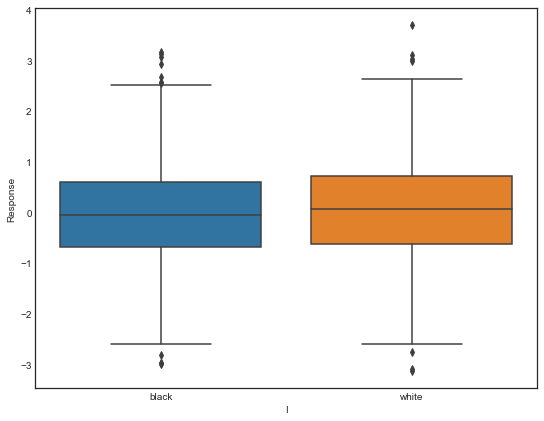

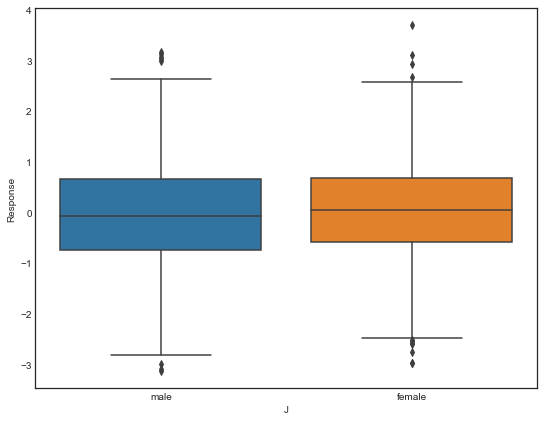

In [14]:
# Using above defined function for boxplots

categories = "I J".split()

boxplots(data, categories, "Response")

Here we can see that categories "female" and "white" has a very small impact on Response, since there is a small median change between each subcategory.

### Multiple Linear Regression

In [15]:
# Assigning dummy variables

data_new = pd.get_dummies(data, drop_first = True)
data_new.head(5) 

,A,B,C,D,E,F,G,H,Response,I_white,J_male
0,-345.694695,-0.229175,-1.481270,1.659987,-1.172292,-0.256532,1.633161,0.277218,-1.878414,0,1
1,209.548322,1.886725,0.213200,-1.150973,1.242473,-0.717337,1.794418,-1.475029,0.770835,1,1
2,191.133034,-1.666423,1.200566,0.427946,-0.314049,0.633903,-0.349396,-0.625093,0.958645,1,1
3,-96.734132,-0.380127,-1.167657,-0.834316,0.484875,0.061835,0.674873,0.208940,-0.738064,1,1
4,338.020349,-1.222810,0.540495,0.021875,-1.038014,0.988782,0.643261,-2.135315,0.937555,1,0


In [16]:
model_A = smf.ols(formula = "Response ~ A + B + C + D + E + F + G + H + I_white + J_male", data = data_new).fit()
model_A.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Response   R-squared:                       0.717
Model:                            OLS   Adj. R-squared:                  0.716
Method:                 Least Squares   F-statistic:                     504.5
Date:                Sun, 10 May 2020   Prob (F-statistic):               0.00
Time:                        15:56:57   Log-Likelihood:                -1582.2
No. Observations:                2000   AIC:                             3186.
Df Residuals:                    1989   BIC:                             3248.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5447      0.022     24.680      0.000       0.501       0.588
A              0.0087      0.000     70.711      0.000       0.008       0.009
B              0.0010      0.012      0.087      0.931      -0.022       0.024
C             -0.5878      0.015    -39.749      0.000      -0.617      -0.559
D             -0.0067      0.012     -0.567      0.570      -0.030       0.016
E              0.0036      0.012      0.291      0.771      -0.020       0.027
F             -0.1824      0.012    -14.826      0.000      -0.207      -0.158
G             -0.1296      0.012    -10.626      0.000      -0.154      -0.106
H             -0.0057      0.012     -0.485      0.628      -0.029       0.018
I_white       -1.1571      0.030    -38.962      0.000      -1.215      -1.099
J_male        -0.0026      0.024     -0.109      0.913      -0.050       0.044
==============================================================================
Omnibus:                        1.856   Durbin-Watson:                   1.962
Prob(Omnibus):                  0.395   Jarque-Bera (JB):                1.786
Skew:                          -0.045   Prob(JB):                        0.409
Kurtosis:                       3.115   Cond. No.                         424.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

From the summary table we can see that Prob(F-statistic) = 0.00, which indicates that our full model rejects the null hyphothesis, which states that all coefficients must be zero. Thus, we can conclude that response can be explained by the predictors, in other words we have a relationship between the predictors and response.

Lets remove one by one all variables which are not statistically significant and have a higher p-value than 0.05 and perform linear regression to compare Adjusted R-squared values (this helps us to understand that dropped variable is important, although it has a p-value bigger than 0.05) 

In [17]:
# Removing variable B
model_A_1 = smf.ols(formula = "Response ~ A + C + D + E + F + G + H + I_white + J_male", data = data_new).fit()
model_A_1.rsquared_adj

0.7159514014591917

In [18]:
# Removing variable D
model_A_2 = smf.ols(formula = "Response ~ A + C + E + F + G + H + I_white + J_male", data = data_new).fit()
model_A_2.rsquared_adj

0.7160475418880579

In [19]:
# Removing variable E
model_A_3 = smf.ols(formula = "Response ~ A + C + F + G + H + I_white + J_male", data = data_new).fit()
model_A_3.rsquared_adj

0.716178807037037

In [20]:
# Removing variable H
model_A_4 = smf.ols(formula = "Response ~ A + C + F + G + I_white + J_male", data = data_new).fit()
model_A_4.rsquared_adj

0.7162891814368412

In [21]:
# Removing variable J_male
model_A_4 = smf.ols(formula = "Response ~ A + C + F + G + I_white", data = data_new).fit()
model_A_4.rsquared_adj

0.7164300828917187

We saw that variables that had p-values bigger than 0.05 have no impact on our Adjusted R-squared, so we can construct the model without them.

In [22]:
model_B = smf.ols(formula = "Response ~ A + C + F + G + I_white", data = data_new).fit()
model_B.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Response   R-squared:                       0.717
Model:                            OLS   Adj. R-squared:                  0.716
Method:                 Least Squares   F-statistic:                     1011.
Date:                Sun, 10 May 2020   Prob (F-statistic):               0.00
Time:                        15:56:57   Log-Likelihood:                -1582.5
No. Observations:                2000   AIC:                             3177.
Df Residuals:                    1994   BIC:                             3211.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5433      0.019     28.871      0.000       0.506       0.580
A              0.0087      0.000     70.938      0.000       0.008       0.009
C             -0.5878      0.015    -39.886      0.000      -0.617      -0.559
F             -0.1829      0.012    -14.924      0.000      -0.207      -0.159
G             -0.1302      0.012    -10.702      0.000      -0.154      -0.106
I_white       -1.1564      0.030    -39.106      0.000      -1.214      -1.098
==============================================================================
Omnibus:                        1.880   Durbin-Watson:                   1.960
Prob(Omnibus):                  0.391   Jarque-Bera (JB):                1.815
Skew:                          -0.044   Prob(JB):                        0.403
Kurtosis:                       3.118   Cond. No.                         414.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [23]:
y = data_new.Response

X = data_new.drop(["Response"], axis = 1)

model_A = LinearRegression()
model_A.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [24]:
model_A_cv_score = cross_val_score(model_A, X, y, scoring = "r2", cv = 10)
score_A = np.mean(model_A_cv_score)
score_A

0.7109572747157407

In [25]:
y_B = data_new.Response

X_B = data_new.drop(["Response", "B", "D", "E", "H", "J_male"], axis = 1)

model_B = LinearRegression()
model_B.fit(X_B, y_B)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [26]:
model_B_cv_score = cross_val_score(model_B, X_B, y_B, scoring = "r2", cv = 10)
score_B = np.mean(model_B_cv_score)
score_B

0.712270418466898

In [27]:
adj_score_A = adj_rsquared(model_A, X, y)
adj_score_A

0.7158096624613948

In [28]:
adj_score_B = adj_rsquared(model_B, X_B, y_B)
adj_score_B

0.7164300828917187

Comparing model_A and model_B scores, we can see that model_B has a slightly better performance, since it has a little bit bigger R-squared and Adjusted R-squared compared with the model_A.

In [29]:
model_B_SM = smf.ols(formula = "Response ~ A + C + F + G + I_white", data = data_new).fit()
model_B_SM.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Response   R-squared:                       0.717
Model:                            OLS   Adj. R-squared:                  0.716
Method:                 Least Squares   F-statistic:                     1011.
Date:                Sun, 10 May 2020   Prob (F-statistic):               0.00
Time:                        15:56:58   Log-Likelihood:                -1582.5
No. Observations:                2000   AIC:                             3177.
Df Residuals:                    1994   BIC:                             3211.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5433      0.019     28.871      0.000       0.506       0.580
A              0.0087      0.000     70.938      0.000       0.008       0.009
C             -0.5878      0.015    -39.886      0.000      -0.617      -0.559
F             -0.1829      0.012    -14.924      0.000      -0.207      -0.159
G             -0.1302      0.012    -10.702      0.000      -0.154      -0.106
I_white       -1.1564      0.030    -39.106      0.000      -1.214      -1.098
==============================================================================
Omnibus:                        1.880   Durbin-Watson:                   1.960
Prob(Omnibus):                  0.391   Jarque-Bera (JB):                1.815
Skew:                          -0.044   Prob(JB):                        0.403
Kurtosis:                       3.118   Cond. No.                         414.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [30]:
for j in np.arange(X_B.shape[1]):
    print(X_B.columns[j], "   VIF->", variance_inflation_factor(X_B.values,j))

A    VIF-> 1.8057637048701038
C    VIF-> 1.4704571712904453
F    VIF-> 1.0472523452054772
G    VIF-> 1.026997623028339
I_white    VIF-> 1.2372112168021354


VIF function does not show any correlated metrics, so we must proceed with further investigating model_B without constructing new model_C by VIF elimination.

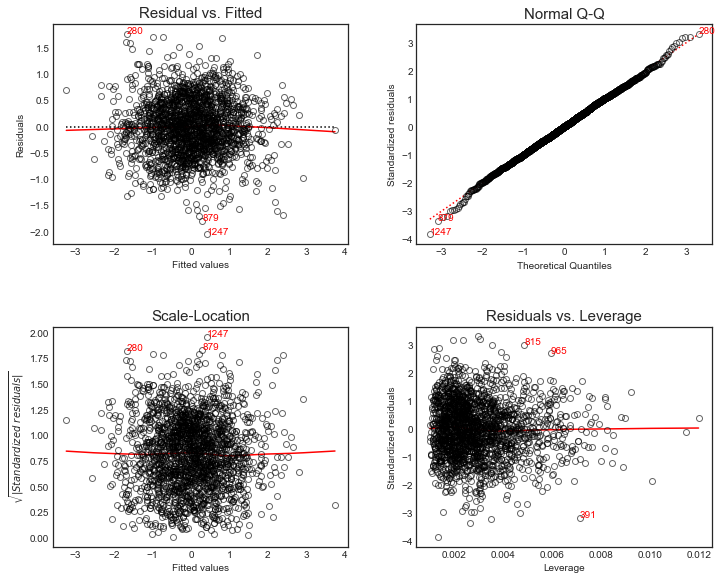

In [31]:
plt.figure(figsize = (10, 8))
lmdiag.plot(model_B_SM)
plt.show()

Residual vs. Fitted: Here we can see that the points are spread around the 0 line and we can conclude that there is no any relationship between residuals and fitted values. This indicates that model performs well.

Normal Q-Q: This plot states that we have a normally distributed residuals, which also confirms that the model performs well.

Scale-Location: Similarly as Residual vs. Fitted plot, this plot shows us that there is no correlation between standardized residuals and fitted values. Conclusion is the same that model is appropriate.

Residuals vs. Leverage: By investigating this plot, we can conclude that there are no points that have unusual input, in other words leverage points. X axis shows the leverage score, and we can't find any point that lmdiag assumes to be leverage. We also can state that we have several outliers, but they do not have high leverage.


We can conclude that model_B can be acceptable for further usage by comparing with model_A, and investigating diagnostic plots.

### Lasso Regression

In [32]:
model_L = LassoCV(n_alphas = 500, cv = 10, max_iter = 10000, normalize = True)

X = data_new.drop(["Response"], axis = 1)
y = data_new.Response

model_L.fit(X, y)

LassoCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
        max_iter=10000, n_alphas=500, n_jobs=None, normalize=True,
        positive=False, precompute='auto', random_state=None,
        selection='cyclic', tol=0.0001, verbose=False)

In [33]:
# Optimal alpha value
model_L.alpha_

0.00011193422273494528

In [34]:
col_list = X.columns
coef_list = model_L.coef_
list(zip(col_list, coef_list))

[('A', 0.008489945880529572),
 ('B', 0.0),
 ('C', -0.5706101150560573),
 ('D', -0.0016999761091915986),
 ('E', 0.0),
 ('F', -0.17408602032661952),
 ('G', -0.12269302433731841),
 ('H', -0.0013588106168164612),
 ('I_white', -1.1226759017981762),
 ('J_male', -0.0)]

In above cell we can see that features B, E and J_male have a coefficient of 0. So Lasso suggests that important variables are A, C, D, F, G, H, I_white.

In [35]:
model_B_SM.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Response   R-squared:                       0.717
Model:                            OLS   Adj. R-squared:                  0.716
Method:                 Least Squares   F-statistic:                     1011.
Date:                Sun, 10 May 2020   Prob (F-statistic):               0.00
Time:                        15:57:14   Log-Likelihood:                -1582.5
No. Observations:                2000   AIC:                             3177.
Df Residuals:                    1994   BIC:                             3211.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5433      0.019     28.871      0.000       0.506       0.580
A              0.0087      0.000     70.938      0.000       0.008       0.009
C             -0.5878      0.015    -39.886      0.000      -0.617      -0.559
F             -0.1829      0.012    -14.924      0.000      -0.207      -0.159
G             -0.1302      0.012    -10.702      0.000      -0.154      -0.106
I_white       -1.1564      0.030    -39.106      0.000      -1.214      -1.098
==============================================================================
Omnibus:                        1.880   Durbin-Watson:                   1.960
Prob(Omnibus):                  0.391   Jarque-Bera (JB):                1.815
Skew:                          -0.044   Prob(JB):                        0.403
Kurtosis:                       3.118   Cond. No.                         414.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Important features for model_B are A, C, F, G, I_white. Comparing with the model_L which has important features A, C, D, F, G, H and I_white, we can see that Lasso selected features D, H to be important predictors as well compared with the model_B, which eliminated these variables. Features A, C, F, G and I_white are included on both model_B and model_L.

We already have R-squared and Adj. R-squared of model_B.

In [36]:
score_B, adj_score_B

(0.712270418466898, 0.7164300828917187)

In [37]:
model_L_score = cross_val_score(model_L, X, y, scoring = "r2", cv = 10)
model_L_r2 = np.mean(model_L_score)
model_L_r2

0.7115743137633798

In [38]:
adj_model_L_r2 = adj_rsquared(model_L, X, y)
adj_model_L_r2

0.7153717723342086

In [39]:
score_B, adj_score_B

(0.712270418466898, 0.7164300828917187)

In [40]:
model_L_r2, adj_model_L_r2

(0.7115743137633798, 0.7153717723342086)

By comparing two metrics, we can see that metrics of model_B, which are score_B and adj_score_B, are slightly higher than metrics of the model_L, which are model_L_r2 and adj_model_L_r2. So we can select model_B to perform better regression analysis.